# Playing Around With Detrending Kepler Lightcurves

## Preliminaries

Load some packages that we will be using:

In [1]:
using CairoMakie
using DataFrames
using HDF5
using FITSIO
using KeplerDetrend
using LaTeXStrings
using LinearAlgebra
using ProgressLogging
using Statistics

Load all the lightcurves from Q1 (that's all I currently have downloaded):

In [2]:
fits_dir = joinpath("..", "lc-files", "HLSP", "Q02")

dfs = []
@progress for f in readdir(fits_dir)
    if endswith(f, ".fits")
        FITS(joinpath(fits_dir, f), "r") do file
            df = DataFrame(file[2]) # Turn the lightcurve into a DataFrame
            df[!, :filename] .= f
            push!(dfs, df)
        end
    end
end

In [3]:
U, S = h5open(joinpath("..", "lc-files", "HLSP", "CBV", "Q02.h5"), "r") do file
    U = read(file, "basis")
    S = read(file, "singular_values")
    U, S
end

([-0.03257251096588554 -0.042346764115078595 … 0.019363564026110787 -0.015663287241939144; -0.03249363226197498 -0.04193777939241561 … 0.010262508510127033 -0.01566328724184563; … ; 0.02425132431829763 -0.030045516094563362 … -0.017642597248576353 -0.015663287241918886; 0.024240480838096094 -0.029960994651037583 … -0.006469227146813795 -0.015663287241947366], [180525.33649682833, 27503.707563469223, 13560.757935573532, 11642.943732670148, 8535.745436837085, 4032.556395131446, 3773.217379360293, 3454.1609708591645, 2892.2000387075095, 2509.609032107846  …  22.79649359549277, 22.76008219990248, 22.716421368853318, 22.63122458842707, 22.501089498165605, 22.436217679541887, 22.336026063932508, 22.16253598073518, 22.090270382933255, 3.1702629878562757e-10])

## Noise Estimate

These lightcurves don't have any error estimate, so let's make one.  We will difference the l.c. (to remove long-term trends), and then take half the variance of the differenced lightcurve.  This is a reasonable estimate of the white-noise level, since if the noise were white and stationary without any trend, it would be the case that 
$$
\mathrm{var} \left( y_{i+1} - y_i \right) = 2 \mathrm{var} \left( y_i \right)
$$

In [5]:
# Now part of KeplerDetrend.jl
# function difference_white_noise_estimate(flux)
#     df = diff(flux)
#     sqrt(var(df)/2)
# end

In [4]:
for df in dfs
    df[!, :FLUX_ERR_EST] .= difference_white_noise_estimate(df.FLUX)
end

## Examine the Data

Let's plot a handful of standardized lightcurves to see what they look like.  There are clear systematic trends:

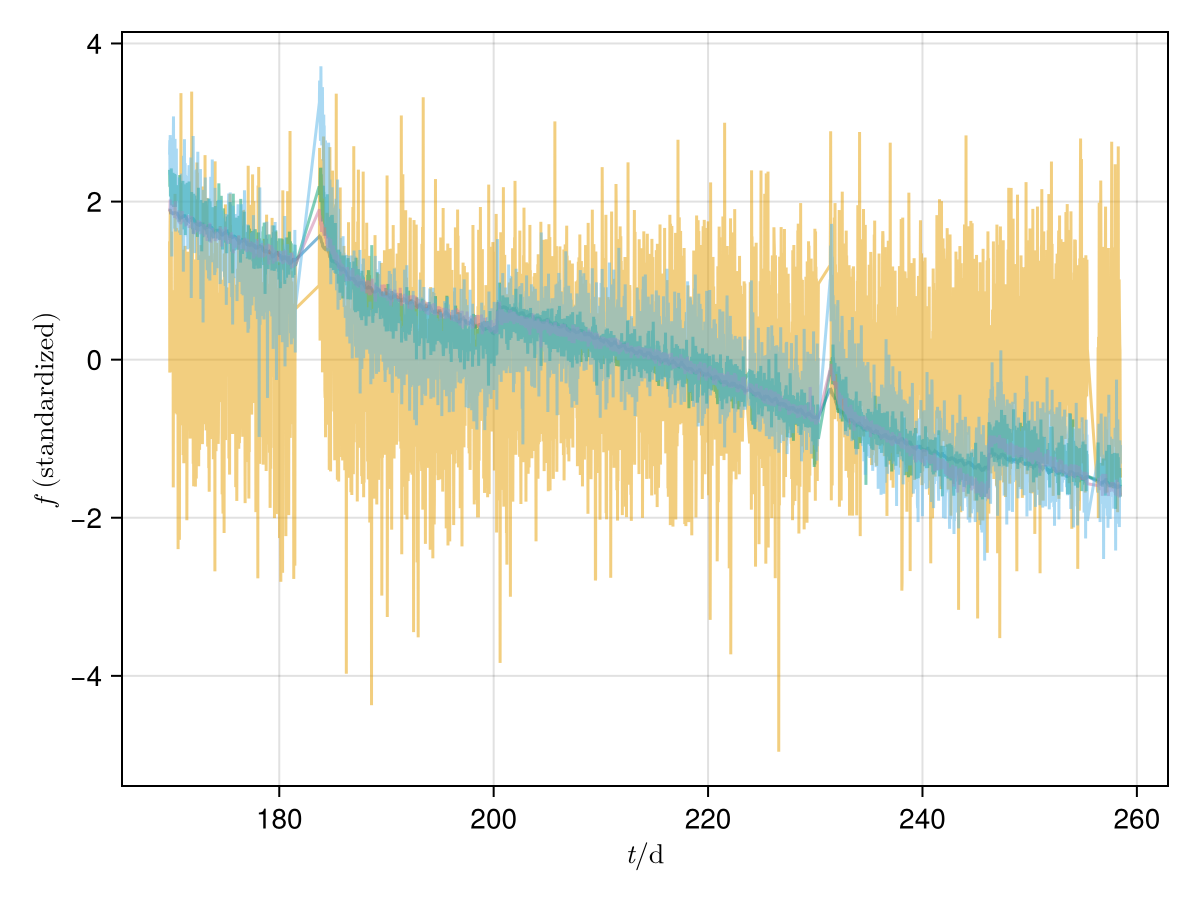

In [5]:
n_plot = 5

f = Figure()
a = Axis(f[1,1], xlabel=L"t / \mathrm{d}", ylabel=L"$f$ (standardized)")

for i in 1:n_plot
    df = dfs[rand(1:length(dfs))]

    flux = (df.FLUX .- mean(df.FLUX)) ./ std(df.FLUX)

    lines!(a, df.TIME, flux, color=Makie.wong_colors(0.5)[i])
end
f

And maybe plot one lightcurve with errorbars estimated:

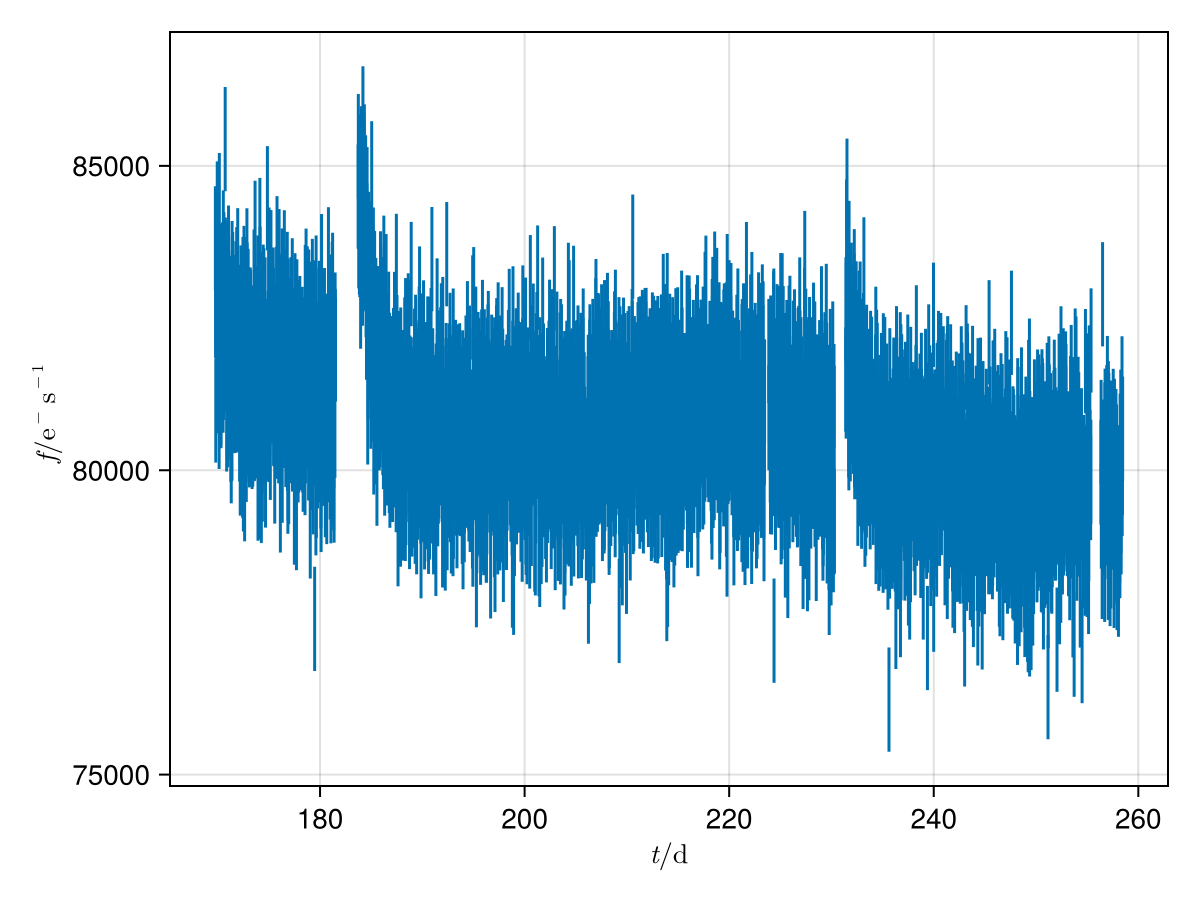

In [6]:
f = Figure()
a = Axis(f[1,1], xlabel=L"t / \mathrm{d}", ylabel=L"$f / \mathrm{e}^- \, \mathrm{s}^{-1}$ ")
errorbars!(a, dfs[1].TIME, dfs[1].FLUX, dfs[1].FLUX_ERR_EST)
f

## Detrending

Let's suppose that we want to find a common (small) set of vectors that give a "best" linear fit to the set of lightcurves.  If we had such a set, we would put it in a design matrix, $M$, and then fit each lightcurve $y_i$, $i = 1, \ldots, N$, using coefficients $x_i$ via
$$
\log \mathcal{L}_i = -\frac{1}{2} \left( y_i - M x_i \right)^T \Sigma_i^{-1} \left( y_i - M x_i \right) + \mathrm{const}.
$$
It is clear from this expression that we can zero out all the part of $y_i$ that lives in the span of the columns of $M$, and then optimal likelihood will be given by 
$$
\log \hat{\mathcal{L}}_i = -\frac{1}{2} \left(y^{\perp}_i \right)^T \Sigma_i^{-1} \left( y^{\perp}_i \right) + \mathrm{const},
$$
where $y^{\perp}_i$ is the part of $y_i$ that is orthogonal to the columns of $M$.  A bit of algebra (optimize the likelihood over $x_i$) reveals that 
$$
y^{\perp}_i = \left( I - M \left( M^T \Sigma_i^{-1} M \right)^{-1} M^T \Sigma_i^{-1} \right) y_i.
$$
(We will not use this expression at all, but it is useful to know that it exists.)  

If we consider the whitened lightcurve, $\tilde{y}_i = L^{-1} y_i$, where $L$ is the Cholesky factor of $\Sigma_i$, so that 
$$
\Sigma_i = L L^T,
$$
and the corresponding whitened $\tilde{y}_i^{\perp} = L^{-1} y_i^{\perp}$ (be careful! whitening the perpindicular $y_i^{\perp}$ is not equivalent to "perpindicularing" the whitened $y_i$), we can write the likelihood as
$$
\log \mathcal{L}_i = -\frac{1}{2} \left( \tilde{y}_i^{\perp} \right)^T \tilde{y}_i^{\perp} + \mathrm{const}.
$$
TODO: there are some subtlties working here in full generality, but I'm too tired to work them out at the moment.

If we specialize to the case where the noise on each lightcurve is homoskedastic (i.e. same noise on each measurement), then whitening and perp-ing commute, and in fact the optimal likelihood for a given $M$ is given by 
$$
\log \hat{\mathcal{L}}_i = -\frac{1}{2 \sigma_i^2} \left( y^{\perp}_i \right)^T y^{\perp}_i + \mathrm{const} = -\frac{1}{2} \left( \tilde{y}^{\perp}_i \right)^T \left( \tilde{y}^{\perp}_i \right) + \mathrm{const},
$$
with $\tilde{y}_i = y_i / \sigma_i$ the "standardized" or "whitened" lightcurve with unit noise variance.  The likelihood for the full set of lightcurves is just summed over each lightcurve, so 
$$
\log \hat{\mathcal{L}} = \sum_i \log \hat{\mathcal{L}}_i = -\frac{1}{2} \sum_i \left( \tilde{y}^{\perp}_i \right)^T \left( \tilde{y}^{\perp}_i \right) + \mathrm{const}.
$$

To find the $M$ that makes this likelihood as large as possible (i.e. the optimal linear detrending design matrix), we can use the SVD: we want to find the subspace of the whitened lightcurves that contains the largest squared length for a given number of components of $M$.  The complementary subspace will have the smallest sum-of-squares over any $N-k$ dimensional subspace.  We can find the desired subspace by taking the SVD of the whitened lightcurves, and then taking the first $k$ singular vectors.  This makes a good basis for the *whitened* lightcurves, but since here whitening is just re-scaling, a basis for the whitened lightcurves is also a good basis for the lightcurves themselves.  If we zero-mean all the whitened lightcurves first, then we ensure that (1) the constant vector has a singular value of zero and (2) the first $k$ singular vectors are orthogonal to the constant vector (i.e. they are zero-mean), so we can adduct the constant vector to the $k$ singular vectors to get a $k+1$ design matrix that simultaneously (1) fits out the mean flux and (2) linearly removes the estimated trends. 

In [7]:
# This is also part of KeplerDetrend.jl
# function full_detrend_basis_and_singular_values(dfs)
#     M = hcat([(df.FLUX .- mean(df.FLUX)) ./ df.FLUX_ERR_EST for df in dfs]...) # Form the matrix whose columns are the whitened lightcurves
#     sM = svd(M)

#     (sM.U, sM.S) # Return the lightcurve basis and singular values
# end

This computation takes a very long time---it's better to load the pre-computed CBVs above than to re-run it yourself.

In [ ]:
U, S = full_detrend_basis_and_singular_values(dfs);

Looking at the singular values, maybe 5 components seems like the inflection point?

┌ Info: Number of CBVs implied by chi2 threshold: 8
└ @ Main /mnt/home/wfarr/KeplerDetrend/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X30sdnNjb2RlLXJlbW90ZQ==.jl:2


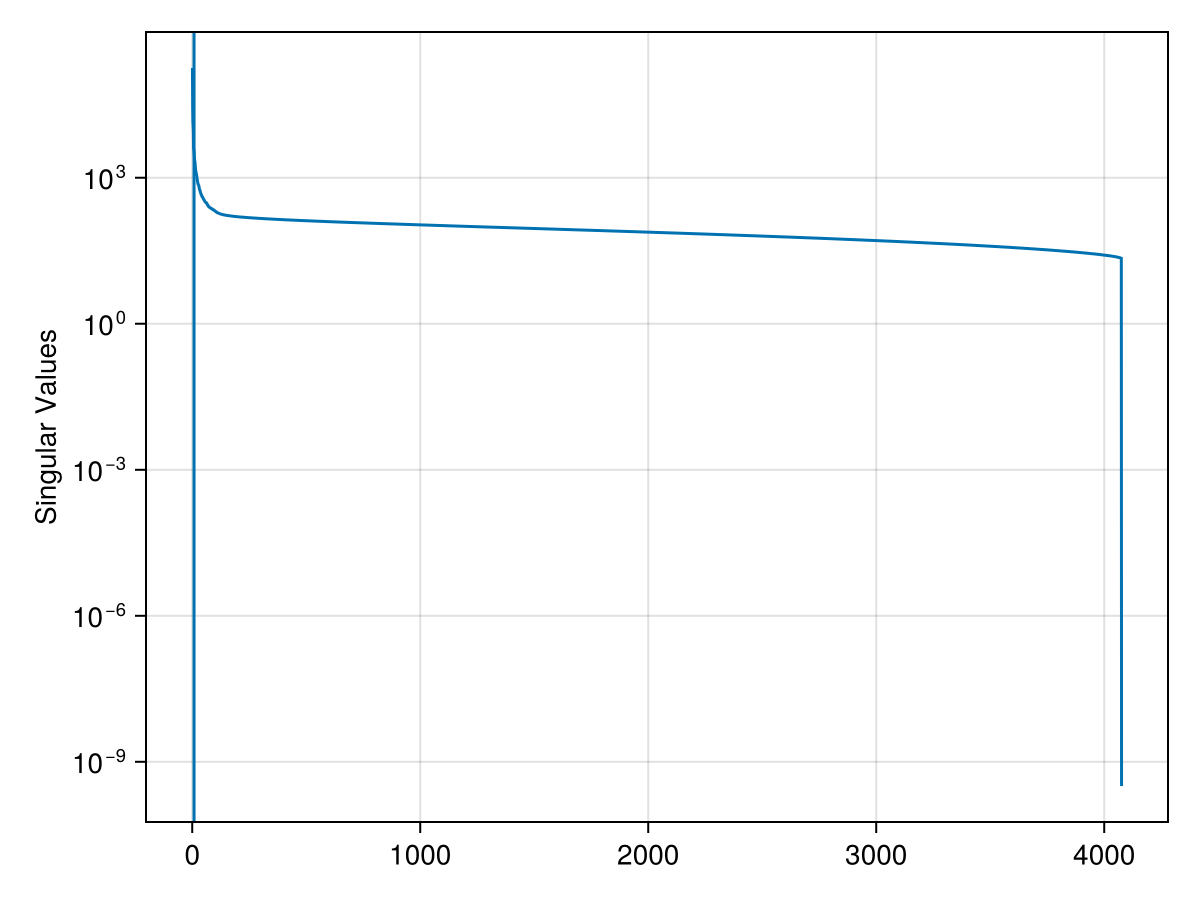

In [ ]:
nc = num_cbvs_threshold(U, dfs; threshold=5.0, flux_col_name="FLUX", flux_err_col_name="FLUX_ERR_EST")
@info "Number of CBVs implied by chi2 threshold: $(nc)"

f = Figure()
a = Axis(f[1,1], ylabel="Singular Values", yscale=log10)
lines!(a, S)
vlines!(a, nc)
f

This function puts in a constant vector (to fit out the l.c. mean) as the first column, and then the desired number of basis vectors in the other columns of the design matrix:

In [9]:
function full_detrend_basis_to_detrend_design_matrix(U, n_detrend)
    nlc = size(U, 1)
    constant_vector = ones(nlc) / sqrt(nlc) # Normalized to unit norm

    [constant_vector U[:, 1:n_detrend]]
end

full_detrend_basis_to_detrend_design_matrix (generic function with 1 method)

In [10]:
detrend_basis = full_detrend_basis_to_detrend_design_matrix(U, nc)

4076×9 Matrix{Float64}:
 0.0156633  -0.0325725  -0.0423468  -0.00452596   …  0.00256839  -0.0416102
 0.0156633  -0.0324936  -0.0419378  -0.00453997      0.00248743  -0.040769
 0.0156633  -0.0324334  -0.0419388  -0.00445704      0.00253829  -0.0410914
 0.0156633  -0.0324162  -0.0419032  -0.00429834      0.00250915  -0.0402351
 0.0156633  -0.0323389  -0.0417069  -0.00394811      0.00215343  -0.0406201
 0.0156633  -0.0322226  -0.0409992  -0.00402459   …  0.00273363  -0.0399701
 0.0156633  -0.0322111  -0.0413975  -0.00362278      0.00218968  -0.0400477
 0.0156633  -0.0321421  -0.0409966  -0.00384752      0.00280153  -0.0394523
 0.0156633  -0.0321181  -0.0412494  -0.00350362      0.00216658  -0.0393673
 0.0156633  -0.0320485  -0.0408119  -0.00347436      0.00222441  -0.0386198
 ⋮                                                ⋱              
 0.0156633   0.0239949  -0.030051   -0.00365941      0.0131335    0.0335922
 0.0156633   0.0241841  -0.0305769  -0.00239152      0.0123888    0.0352305

Let's plot the detrend basis:

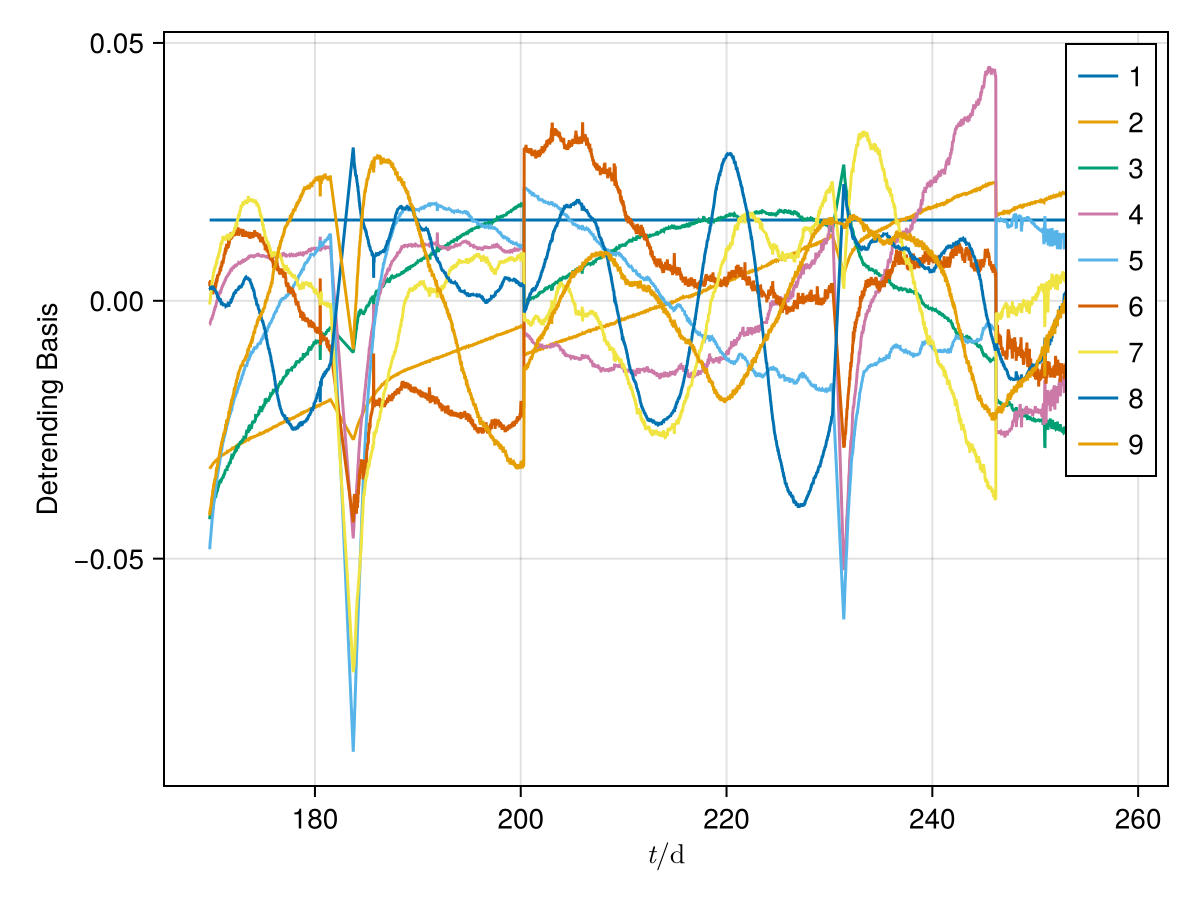

In [11]:
f = Figure()
a = Axis(f[1,1], xlabel=L"t / \mathrm{d}", ylabel="Detrending Basis")
for i in 1:size(detrend_basis, 2)
    lines!(a, dfs[1].TIME, detrend_basis[:, i], label="$i")
end
axislegend(a)
f

This function adds columns to each data frame that are detrended flux, normalized detrended flux (i.e. divided by the estimated mean), and the associated normalized flux uncertainty:

In [12]:
# This function is also part of KeplerDetrend.jl
# function detrend!(df, basis)
#     x = basis \ df.FLUX # Least-squares solution.

#     df[!, :FLUX_DETREND] = df.FLUX - basis[:, 2:end] * x[2:end] # Subtract everything but the mean 
#     df[!, :FLUX_DETREND_NORM] = df.FLUX_DETREND ./ (basis[:, 1] .* x[1]) # Normalize by the mean
#     df[!, :FLUX_DETREND_NORM_ERR_EST] = df.FLUX_ERR_EST ./ (basis[:, 1] .* x[1]) # Normalize by the mean
# end

In [13]:
@progress for df in dfs
    detrend!(df, detrend_basis)
end

A few plots to illustrate how we did:

In [14]:
function do_plot(dfs, i)
    df = dfs[i]

    f = Figure()
    a = Axis(f[1,1], xlabel=L"t / \mathrm{d}", ylabel="Normalized Flux", title="Lightcurve $(i): s.d. $(round(std(df.FLUX_DETREND_NORM), digits=4)) (estimated $(round(df.FLUX_DETREND_NORM_ERR_EST[1], digits=4)))")
    errorbars!(a, df.TIME, df.FLUX_DETREND_NORM, df.FLUX_DETREND_NORM_ERR_EST)
    f
end

do_plot (generic function with 1 method)

For most of the stars, it seems that our estimated white noise level matches pretty precisely the s.d. of the detrended lightcurve!  This suggests that our detrending is working great, and makes us feel really good; but it also makes us disappointed that there are not obvious signs of stellar rotation or spots in these data.

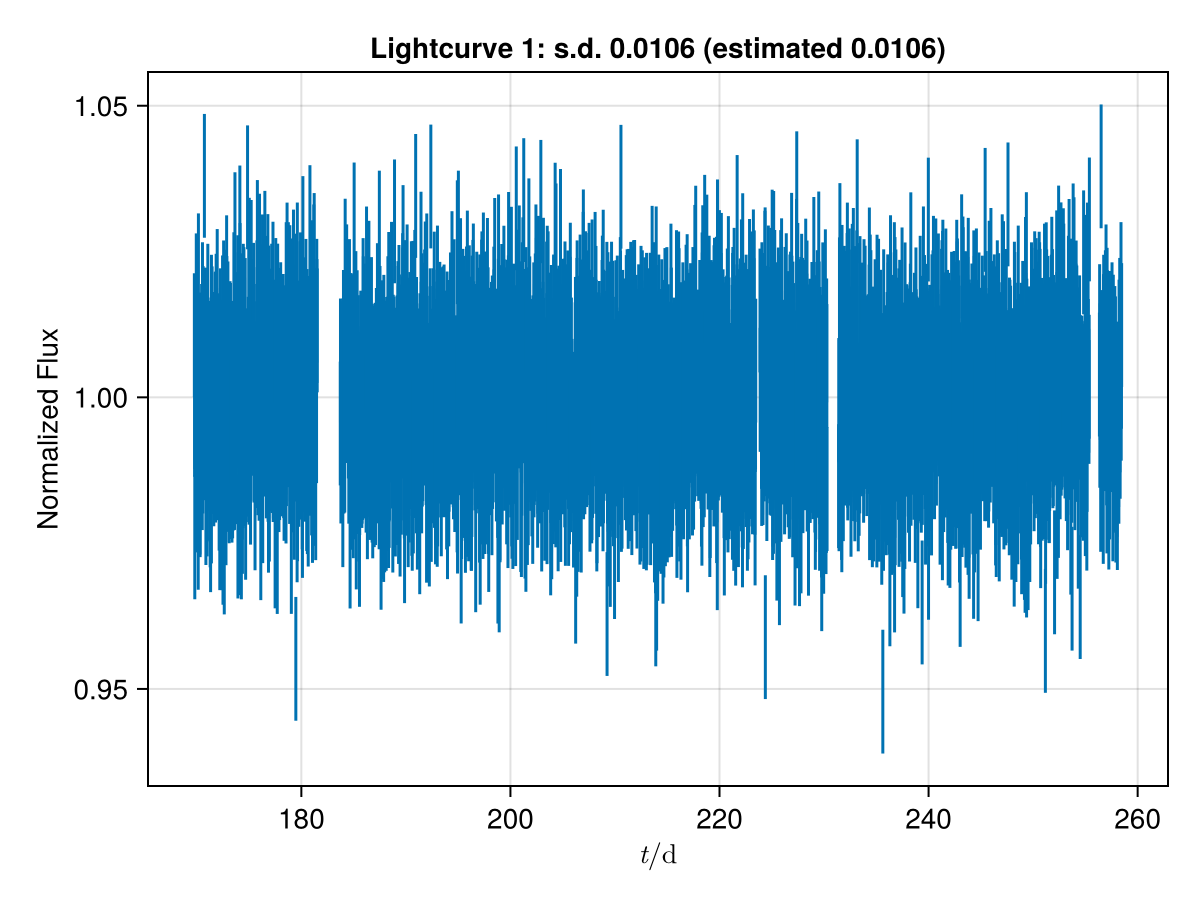

In [15]:
do_plot(dfs, 1)

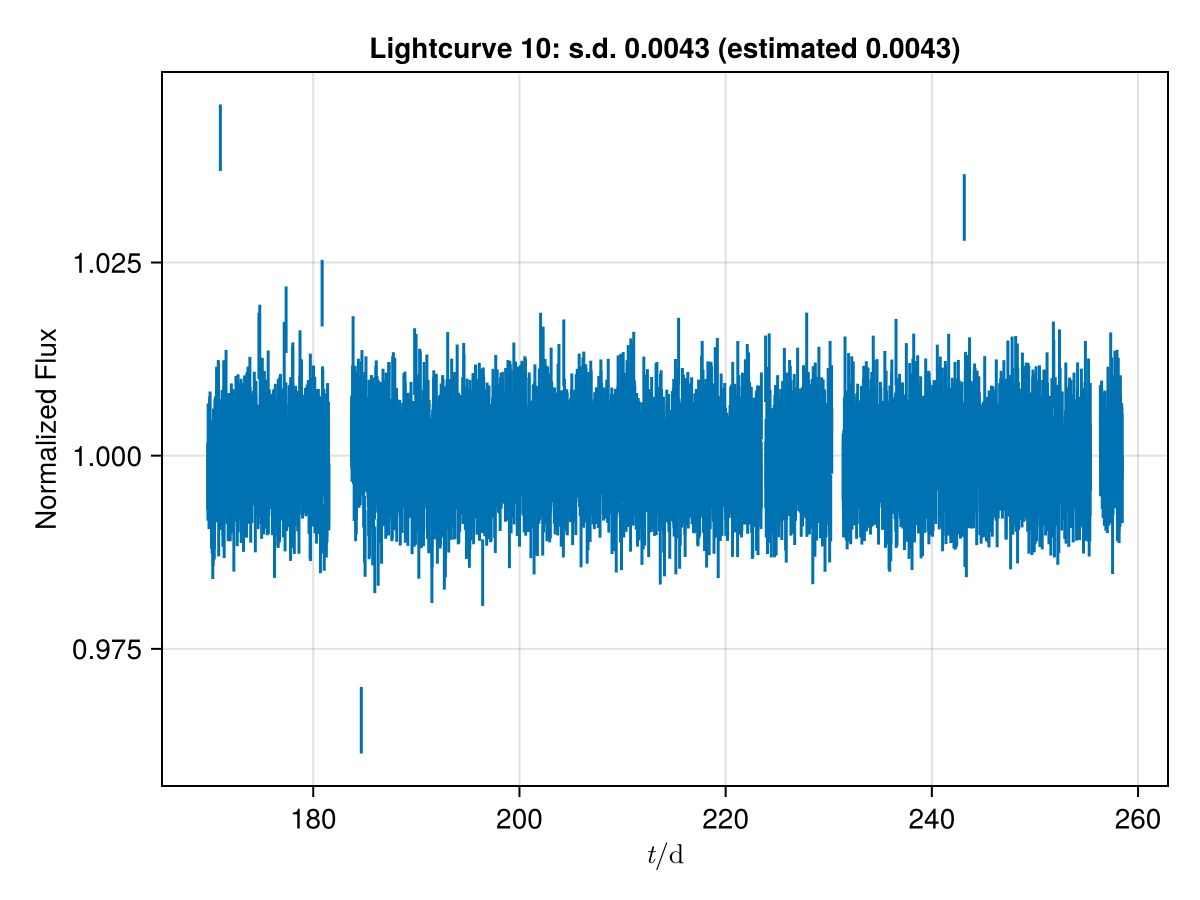

In [16]:
do_plot(dfs, 10)

But a handful of the stars *do* have evidence of rotation or spots, and correspondingly show larger s.d. of the detrended lightcurve than our original estimated white noise level.  (But the extra s.d. is due to the coherent or semi-coherent structure in the lightcurve; our originial noise estimate looks pretty reasonable for these stars.)  This makes us happy, or at least a bit optimistic that we can learn something about rotation from these data....

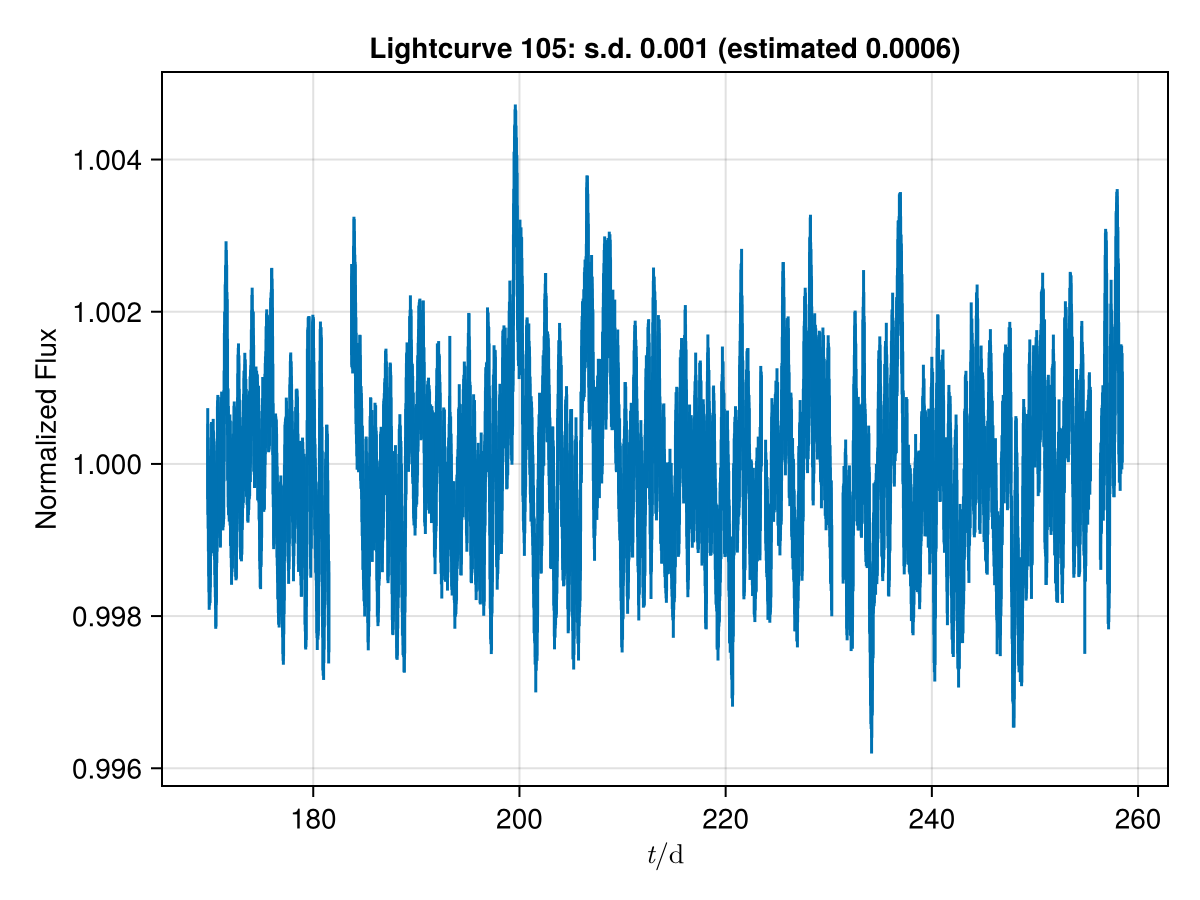

In [23]:
i = rand(1:length(dfs))
do_plot(dfs, i)